In [120]:
!unzip stock.zip

Archive:  stock.zip
replace all_stocks_5yr.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [121]:
!pip install arch

In [122]:
import os
import pandas as pd
import numpy as np
import random
import itertools
from arch import arch_model
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
%matplotlib inline

,CPB,ROST,TSCO,TEL,MCK,BDX,ABBV,PEP
date,,,,,,,,
2013-02-08,37.93,30.53,52.020,40.52,103.80,88.25,36.25,72.60
2013-02-11,38.12,30.43,51.600,40.44,103.53,88.31,35.85,72.36
2013-02-12,38.26,30.33,51.480,40.49,104.83,88.55,35.42,72.17
2013-02-13,38.18,30.22,51.550,40.92,104.91,88.47,35.27,71.50
2013-02-14,38.72,30.19,51.875,41.08,104.21,88.39,36.57,72.28


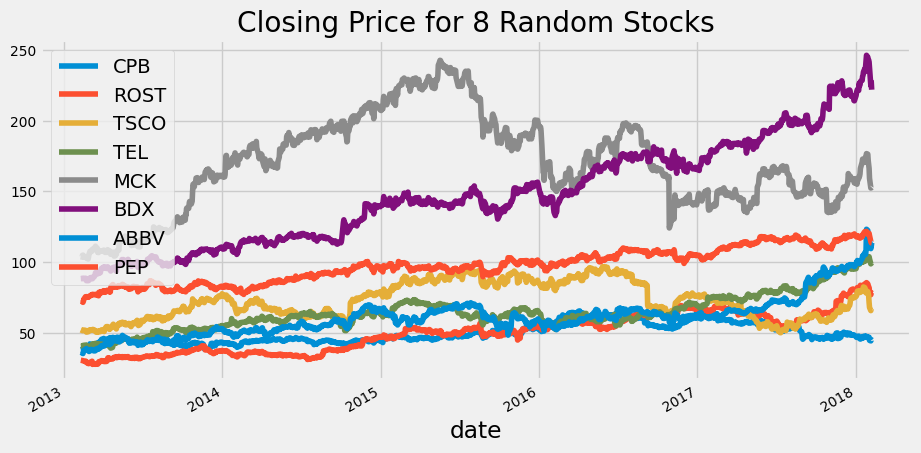

In [123]:
path = '/content/individual_stocks_5yr/individual_stocks_5yr'
csvs = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]

df = pd.DataFrame()
for file in random.sample(range(1, len(csvs)), 8):
    stock_df = pd.read_csv(csvs[file])
    stock_df.index = pd.DatetimeIndex(stock_df.date)
    name = stock_df['Name'].iloc[0]
    df[name] = stock_df['close']

df.plot(figsize=(10, 5), title='Closing Price for 8 Random Stocks')
df.head()

<b>Heterokedasticity</b>: Happens when the variance of the distribution used to construct the time series is a function of time. One common example is a time series where we can see that the variance increases with respect to time.

Small amounts of heteroskedasticity can sometimes be masked by a <b>Box-Cox transformation</b>, which makes the data distribution more normal. However, if the variance change is great and the variance $x_t$ at step $t$ is conditional on the past $x_{t-1}$, we need to have a different way to handle. This is called conditional heterokedasticity or volatility clustering.

From the plot above, we can see different periods with different degree of volatility. The ARCH and GARCH models are designed to model the variance for time series (not to forecast the value). The ARCH and GARCH models specifically capture the expected variance of the residuals from another model. To forecast financial markets we would use ARCH and GARCH after applying another model like <b>ARIMA</b> first.

# Autoregressive Conditional Heteroskedasticity (ARCH)

With ARCH, the variance of the current time step is dependent on $p$ lagged squared standard error terms, each with coefficient $\alpha$. Note that these error terms come from the difference between the observed and predicted value from another model:

$$r_t = \mu + \epsilon_t$$
$$\epsilon_t = \sigma_t e_t$$
$$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_p \epsilon_p^2$$


# Generalized Autoregressive Conditional Heteroskedasticity (GARCH)


GARCH extends ARCH by allowing the variance to depend on its own lags and the lags of the squared residuals:

$$r_t = \mu + \epsilon_t$$
$$\epsilon_t = \sigma_t e_t$$
$$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_p \epsilon_p^2 + \beta_1 \sigma_{t-1}^2 + \cdots + \beta_q \sigma_{t-q}^2$$

GARCH can capture greater changes like increasing and decreasing volatility.

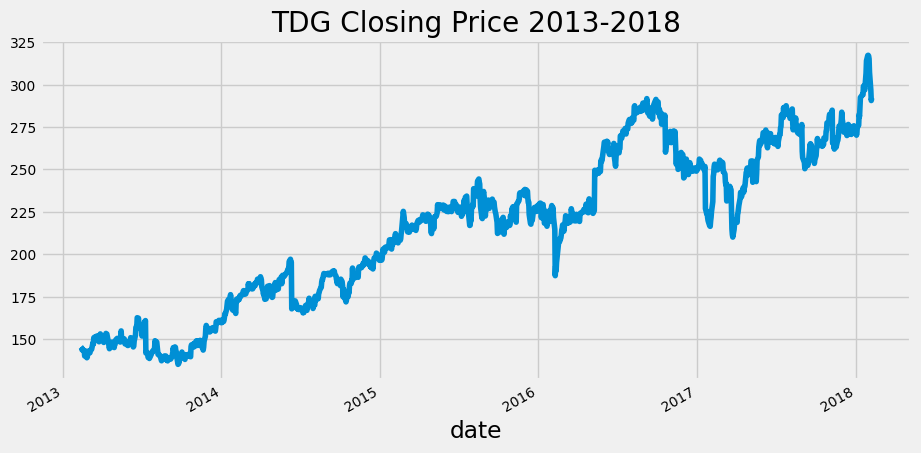

In [124]:
stock = 'TDG'
df = pd.read_csv(f'/content/individual_stocks_5yr/individual_stocks_5yr/{stock}_data.csv')
df.index = pd.DatetimeIndex(df.date)
df = df.drop(columns=['open', 'high', 'low', 'volume', 'date', 'Name'])
df['pct_change'] = 100*df['close'].pct_change()
df.dropna(inplace=True)
df['close'].plot(figsize=(10, 5), title=f'{stock} Closing Price 2013-2018')
plt.show()

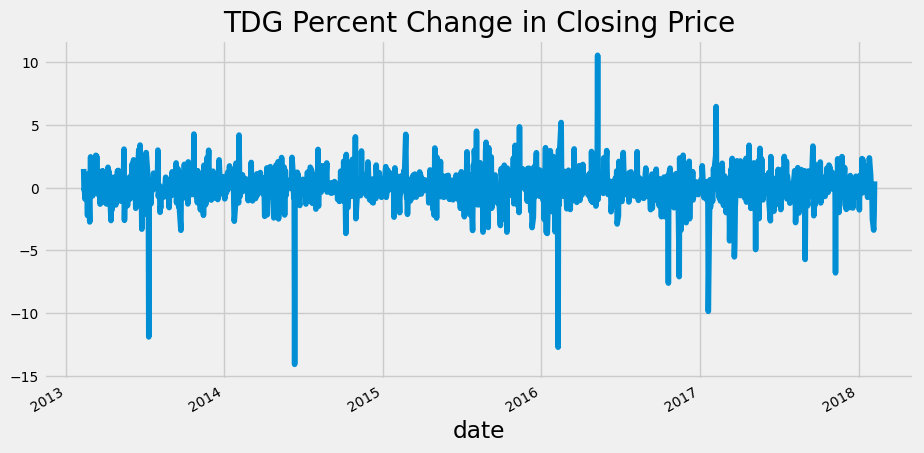

In [125]:
df['pct_change'].plot(figsize=(10, 5), title=f'{stock} Percent Change in Closing Price')
plt.show()

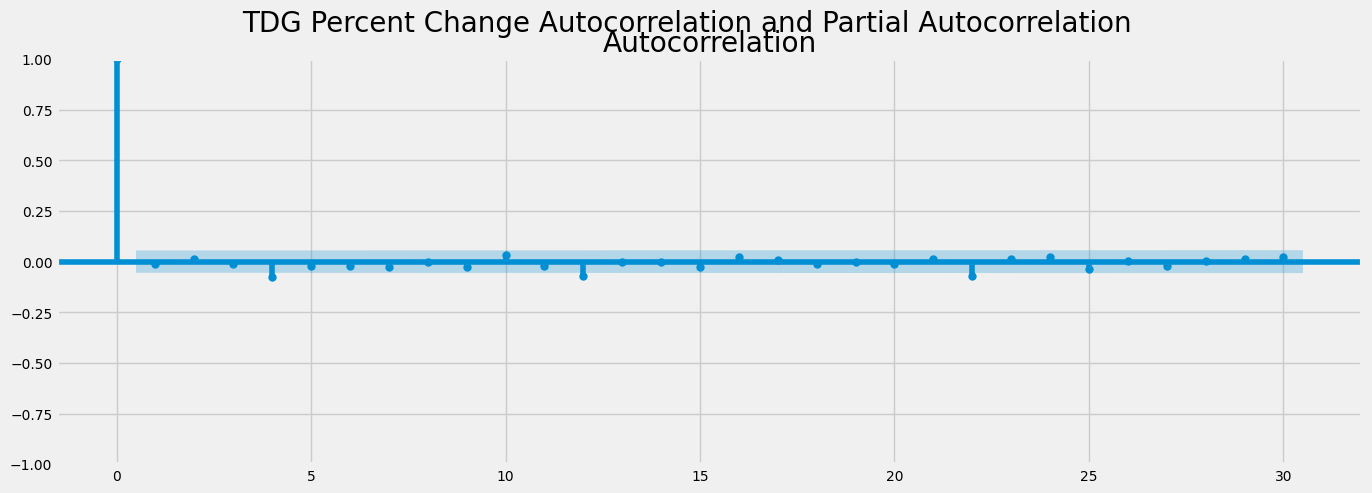

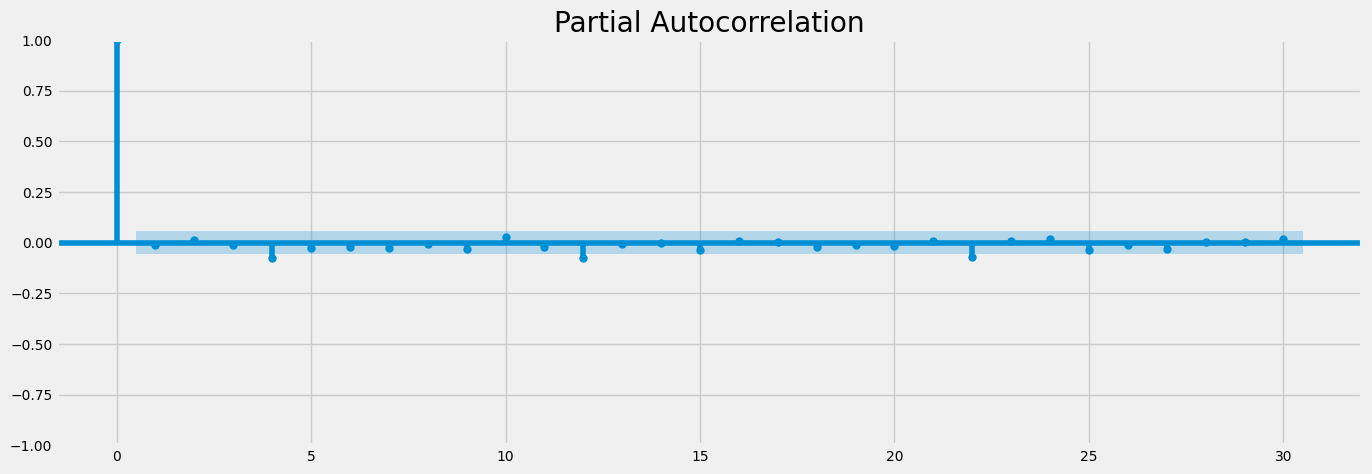

In [126]:
acf = plot_acf(df['pct_change'], lags=30)
pacf = plot_pacf(df['pct_change'], lags=30)
acf.suptitle(f'{stock} Percent Change Autocorrelation and Partial Autocorrelation', fontsize=20)
acf.set_figheight(5)
acf.set_figwidth(15)
pacf.set_figheight(5)
pacf.set_figwidth(15)
plt.show()

# Ljung - Box test

This test can be used on the residuals of the model to look for autocorrelation. The hypotheses for the test are as follows:

$$H_0: \text{The data are independently distributed, no autocorrelation (i.e. white noise)}$$
$$H_A: \text{The data are not independently distributed; they exhibit serial correlation}$$

If p-value is less than 0.05, we reject the null hypothesis. Note that ideally, we want our residuals to be white noise.

In [127]:
ljung_res = acorr_ljungbox(df['pct_change'], lags= 40, boxpierce=True)
ljung_res

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.107904,0.742543,0.107647,0.742839
2,0.260044,0.878076,0.259304,0.878401
3,0.455559,0.928541,0.454043,0.928866
4,7.702393,0.103109,7.666369,0.104593
5,8.427964,0.134174,8.387908,0.136113
6,9.134358,0.166162,9.089818,0.168589
7,9.981917,0.189601,9.931323,0.192499
8,9.989090,0.265793,9.938438,0.269373
9,10.816118,0.288524,10.758247,0.292645
10,12.141226,0.275716,12.070735,0.280350


In [128]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()

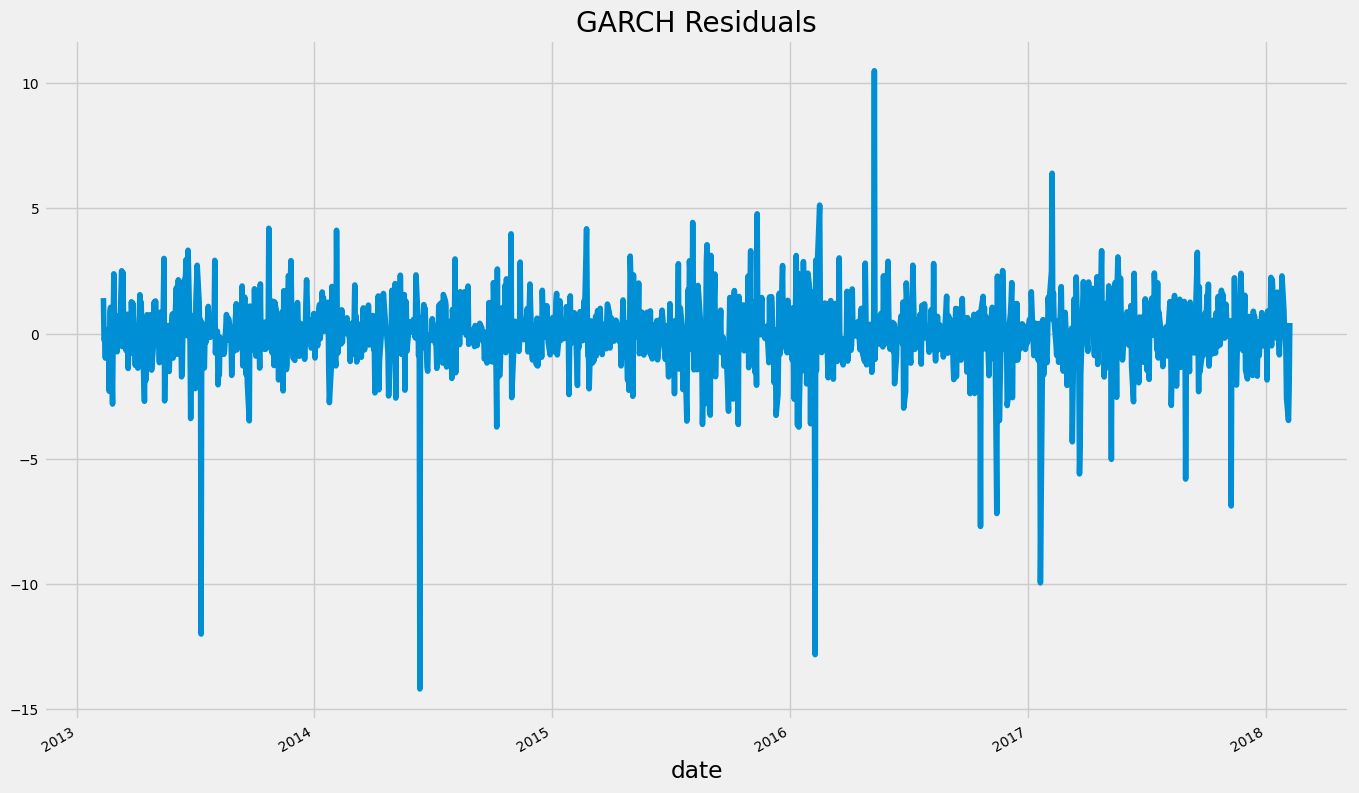

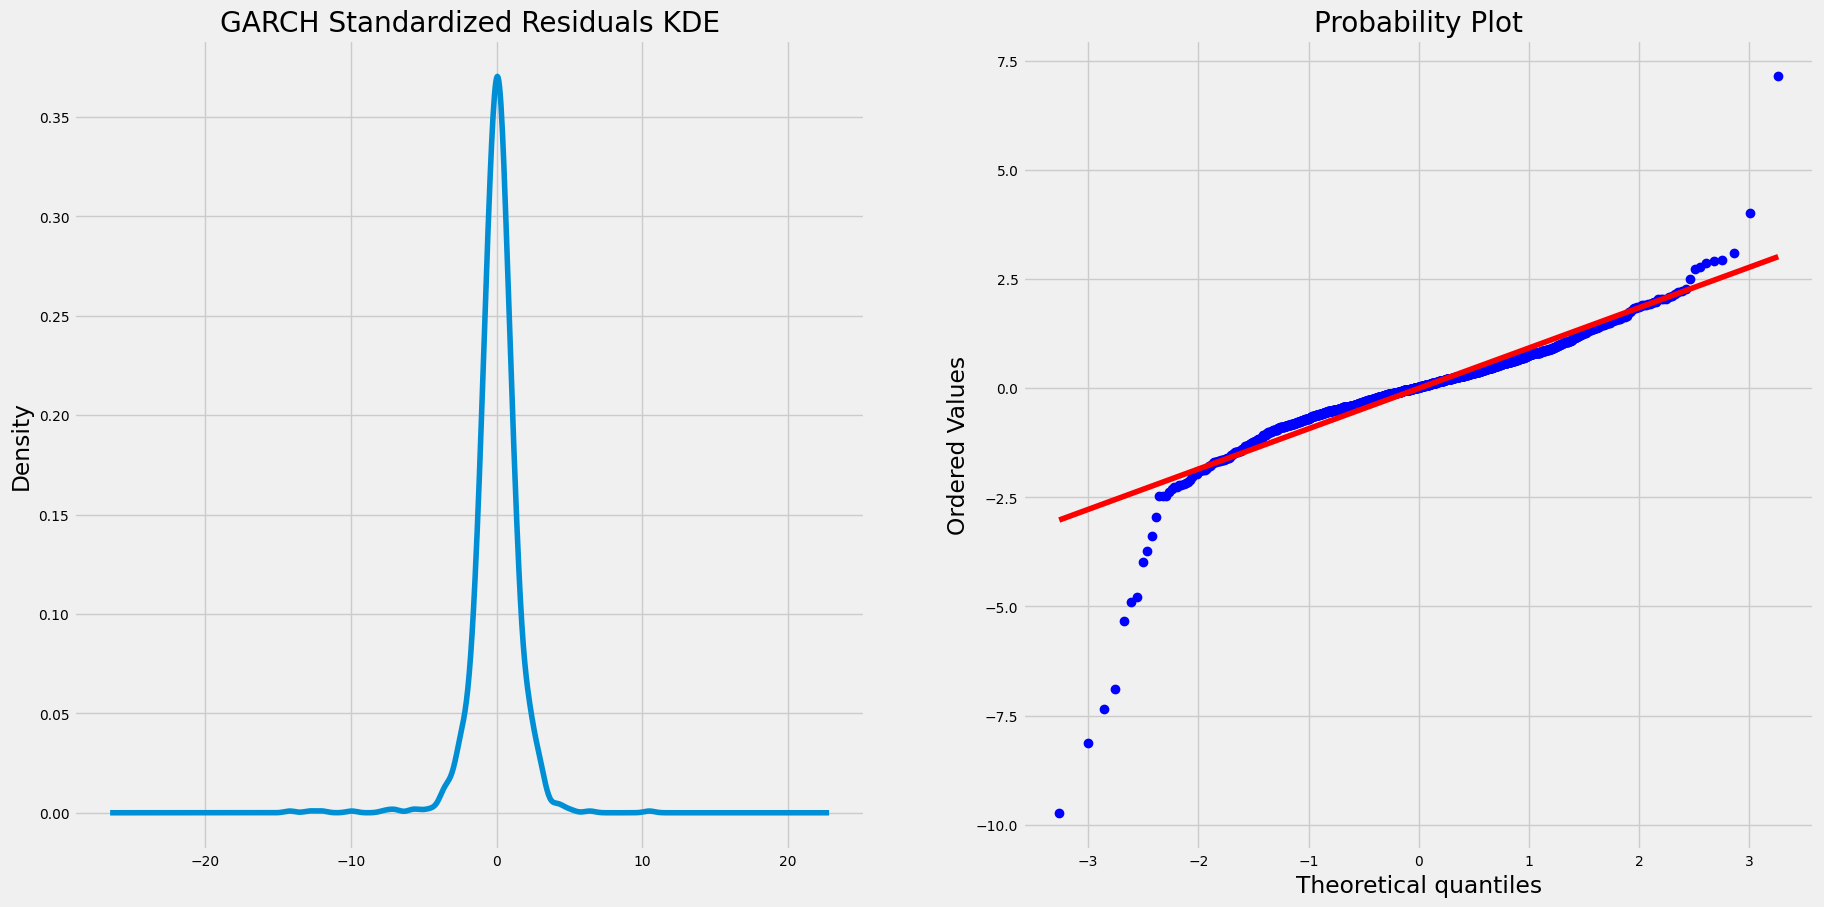

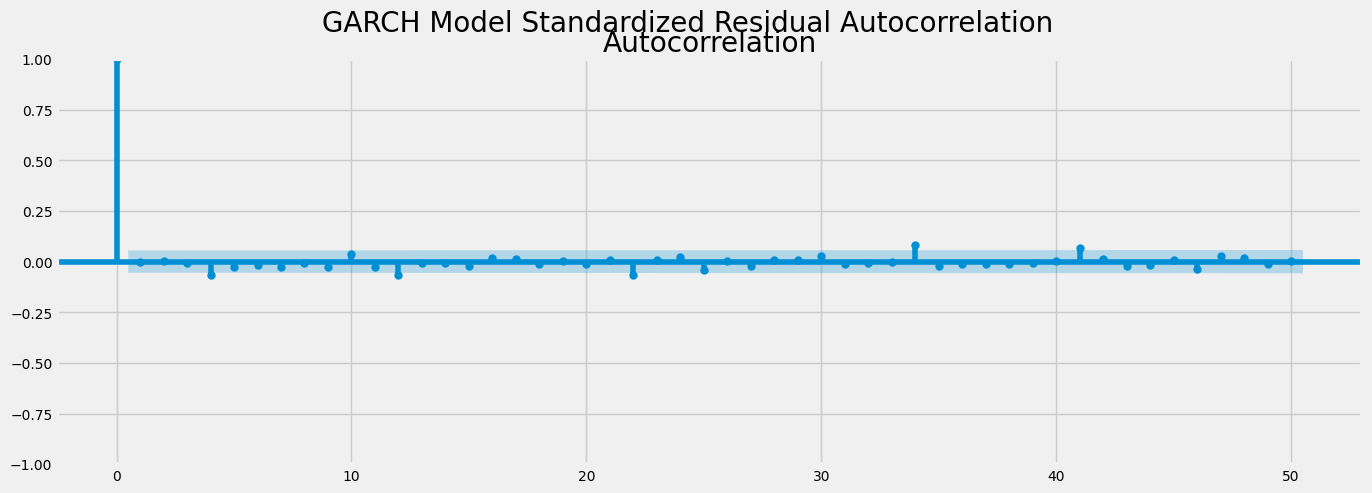

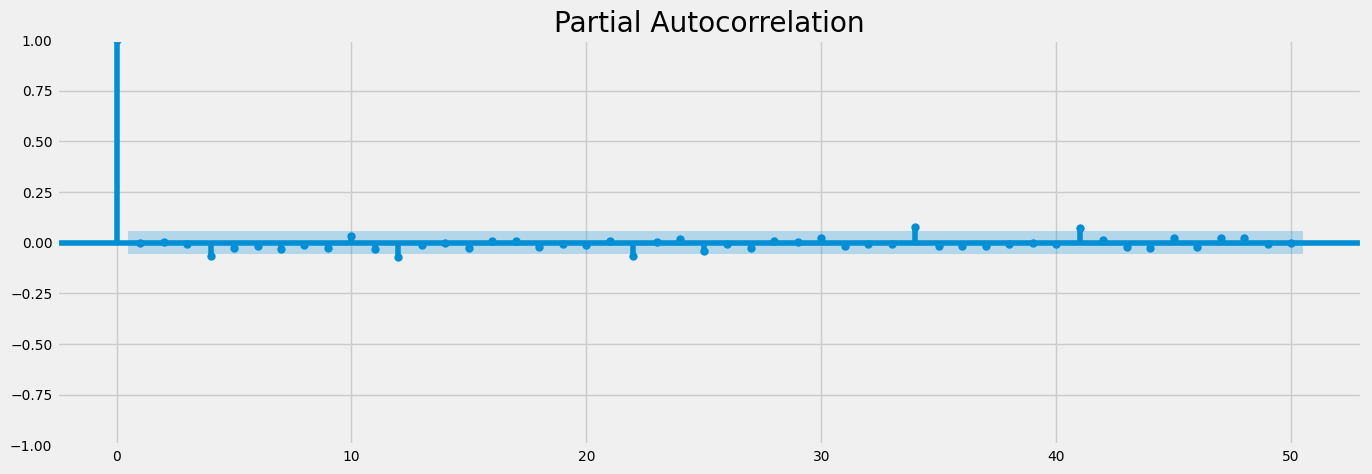

In [129]:
# constant mean GARCH model
garch = arch_model(df['pct_change'], vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(disp='off')
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)

In [130]:
fgarch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2307.11
Distribution:                  Normal   AIC:                           4622.21
Method:            Maximum Likelihood   BIC:                           4642.76
                                        No. Observations:                 1258
Date:                Sun, Jul 21 2024   Df Residuals:                     1257
Time:                        01:25:35   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0755  4.505e-02      1.677  9.359e-02 [-1.276e-02,  0.164]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9758      0.596      1.636      0.102    [ -0.193,  2.145]
alpha[1]       0.0632  9.635e-02      0.656      0.512    [ -0.126,  0.252]
beta[1]        0.5220      0.305      1.711  8.707e-02 [-7.592e-02,  1.120]
===========================================================================

Covariance estimator: robust
"""

In [131]:
arch_test = het_arch(resid, nlags=50)
shapiro_test = shapiro(st_resid)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 0.9999999997772876
F test p-value: 0.9999999998466416
Shapiro-Wilks p-value: 1.812616550134989e-32


In [132]:
def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, nlags=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results

In [133]:
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p=p, q=q, dist='normal')
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_model(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score:
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models

In [134]:
df['pct_change'].min()

-14.105716041794725

In [135]:
p_rng = range(1, 30)
q_rng = range(0, 40)
df['dif_pct_change'] = df['pct_change'].diff()
top_models = gridsearch(df['dif_pct_change'].dropna(), p_rng, q_rng)

In [136]:
print(top_models)

[{'LM_pvalue': [2.2847507393341813e-40, True], 'F_pvalue': [3.241768942784999e-48, True], 'SW_pvalue': [3.23537858086573e-23, True], 'AIC': 5239.482787806397, 'params': {'p': 2, 'q': 0}}]


Note that to measure the fitness of the GARCH model, we can check the followings:

<ul>
<li>Autocorrelation in standardized residuals, using Ljung-Box</li>
<li>Conditional heterokedasticity (a.k.a ARCH effects) using Engle's test</li>
<li>Normal distribution in the standardized residuals, we can use the Shapiro-Wilk test, Q-Q plot, and for large n, the Jarque-Bera test to see if our data approaches normality
</ul>

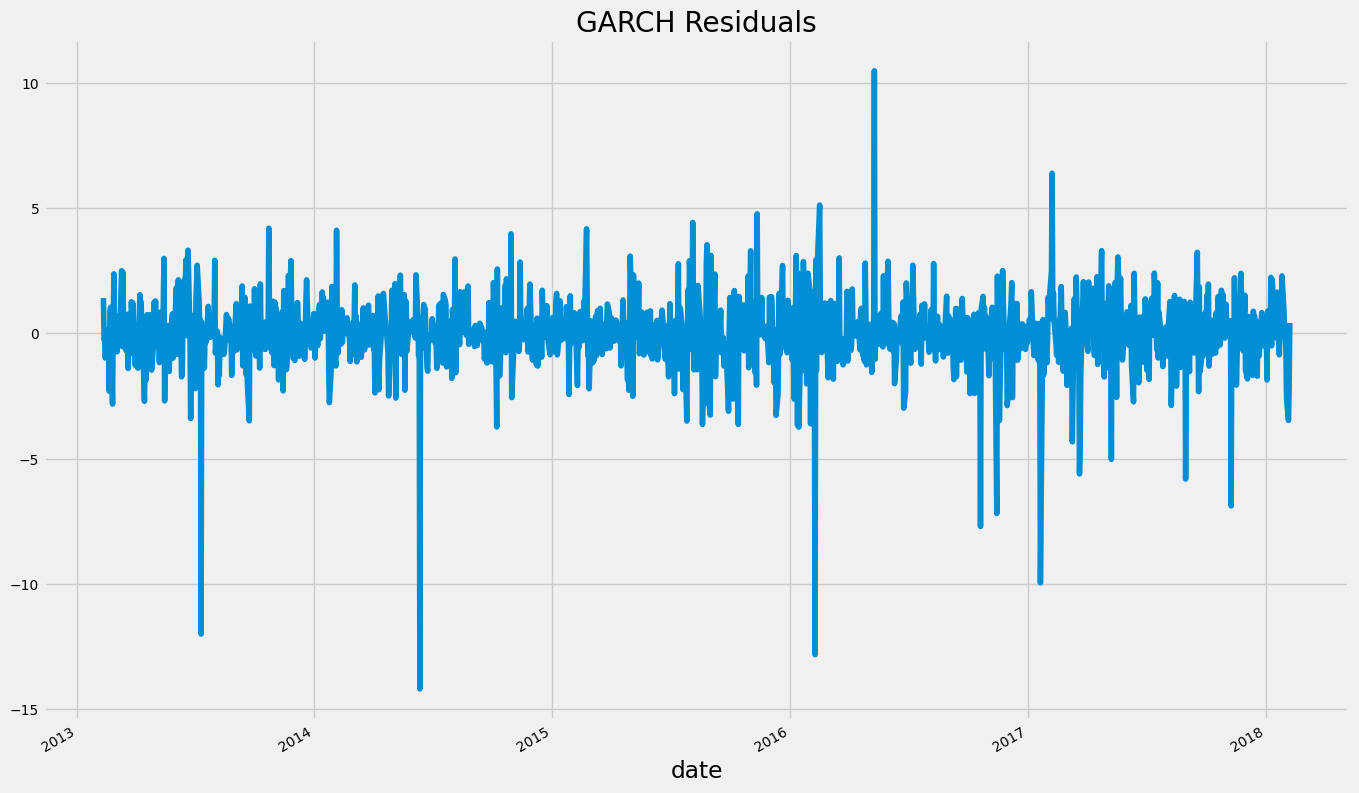

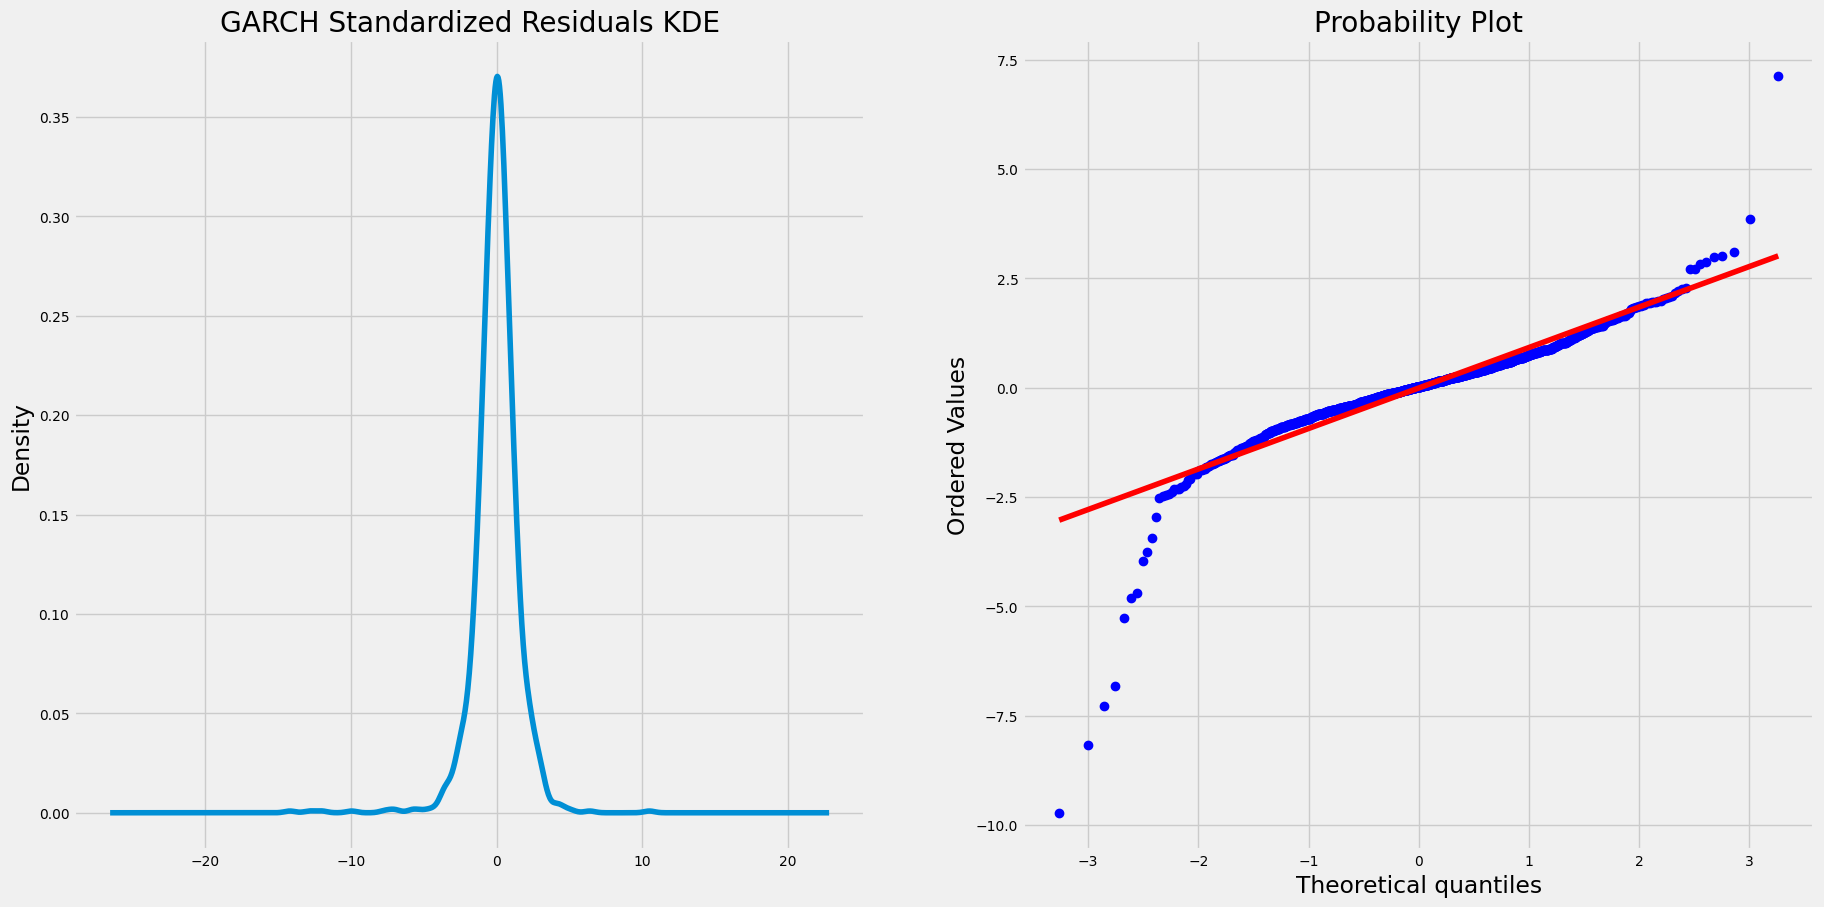

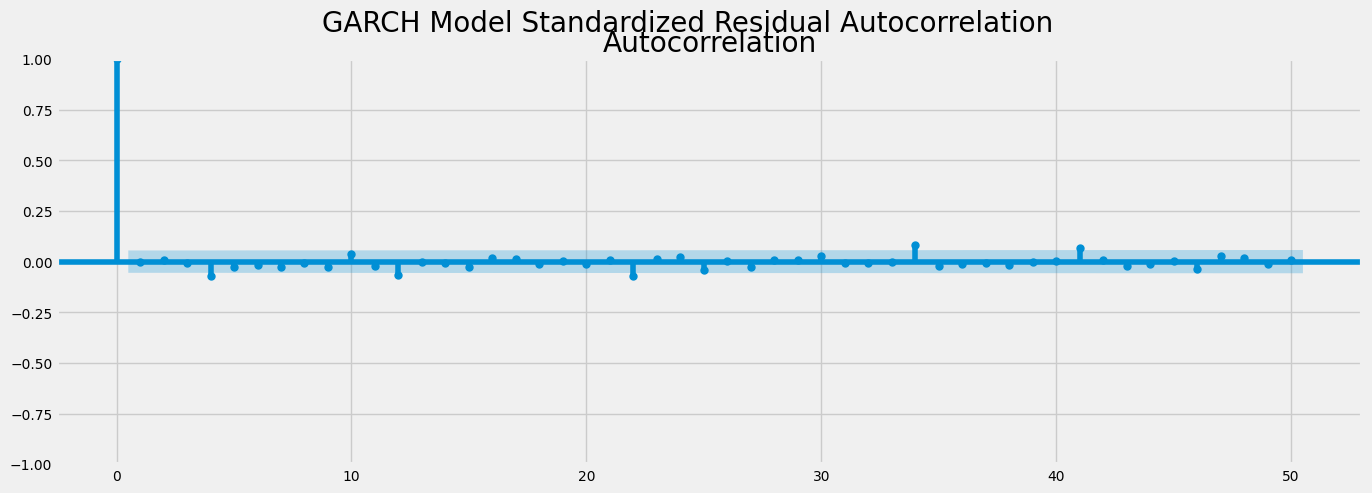

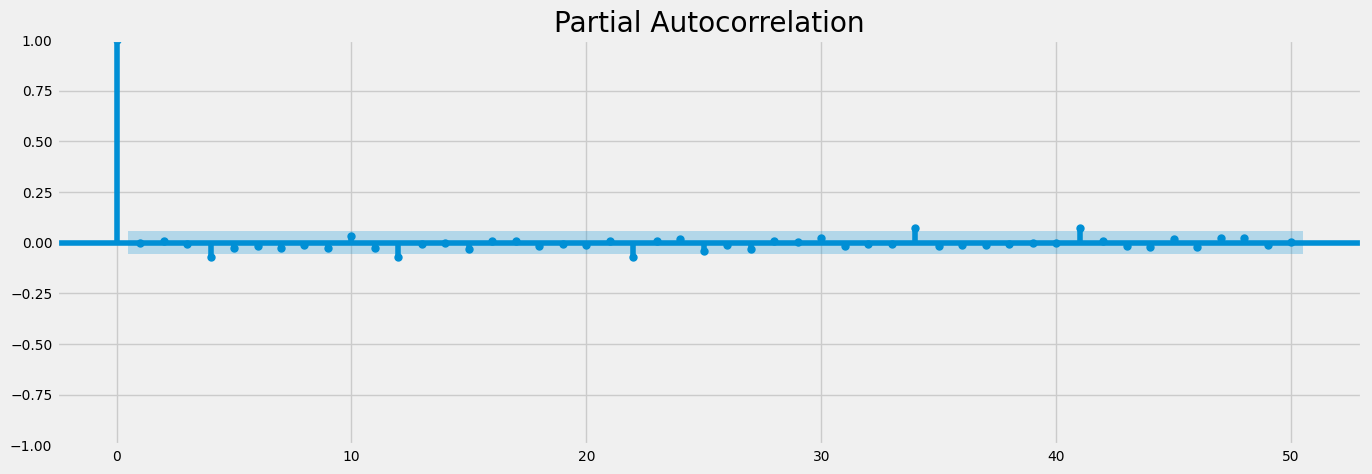

In [137]:
garch = arch_model(df['pct_change'], vol='GARCH', p=2, q=0, dist='normal')
fgarch = garch.fit(disp='off')
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)

In [138]:
arch_test = het_arch(resid, nlags=50)
shapiro_test = shapiro(st_resid)
print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 0.9999999997777593
F test p-value: 0.9999999998469692
Shapiro-Wilks p-value: 2.8309107189906674e-32


In [139]:
fgarch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2307.55
Distribution:                  Normal   AIC:                           4623.10
Method:            Maximum Likelihood   BIC:                           4643.65
                                        No. Observations:                 1258
Date:                Sun, Jul 21 2024   Df Residuals:                     1257
Time:                        01:43:38   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0764  4.098e-02      1.865  6.219e-02 [-3.894e-03,  0.157]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          2.1279      0.331      6.429  1.283e-10      [  1.479,  2.777]
alpha[1]       0.0980      0.127      0.772      0.440      [ -0.151,  0.347]
alpha[2]   7.1559e-13  3.647e-02  1.962e-11      1.000 [-7.149e-02,7.149e-02]
=============================================================================

Covariance estimator: robust
"""

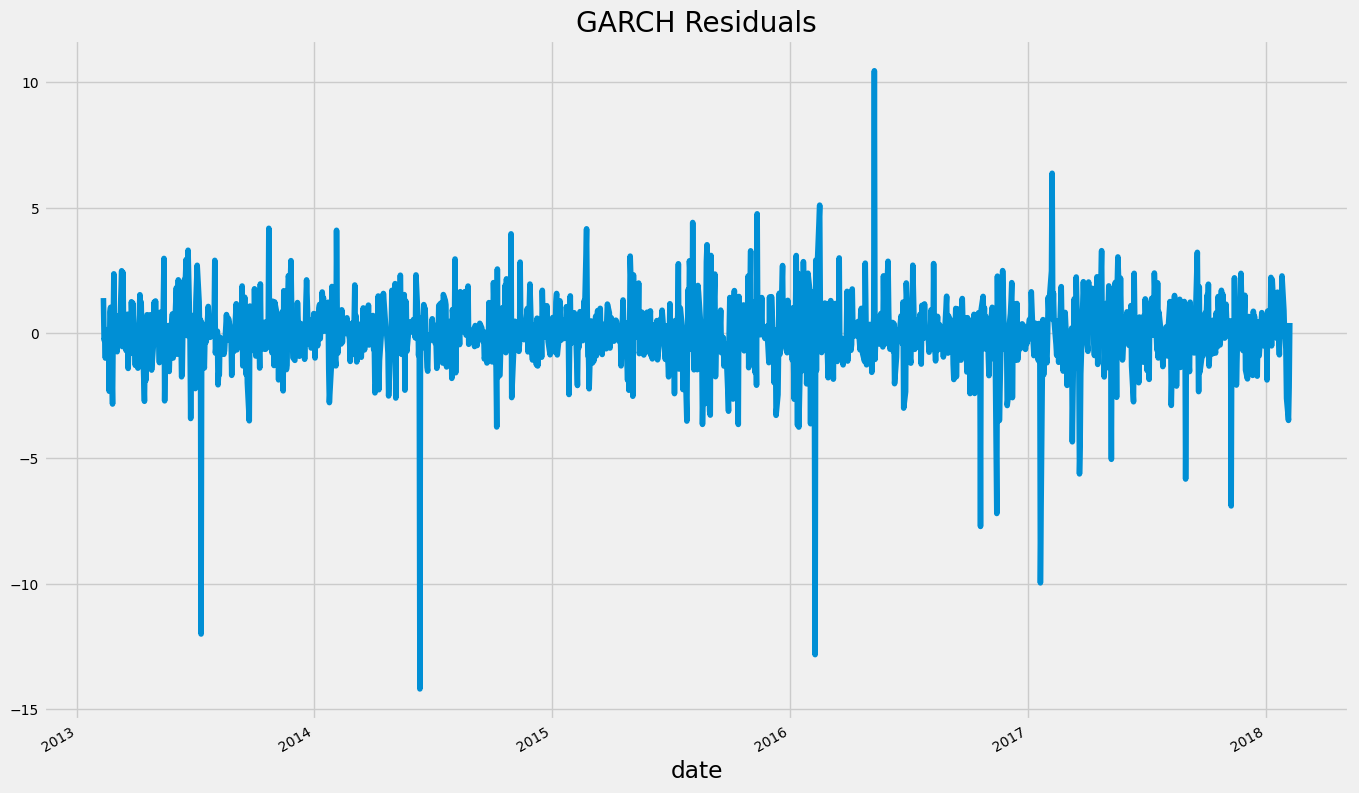

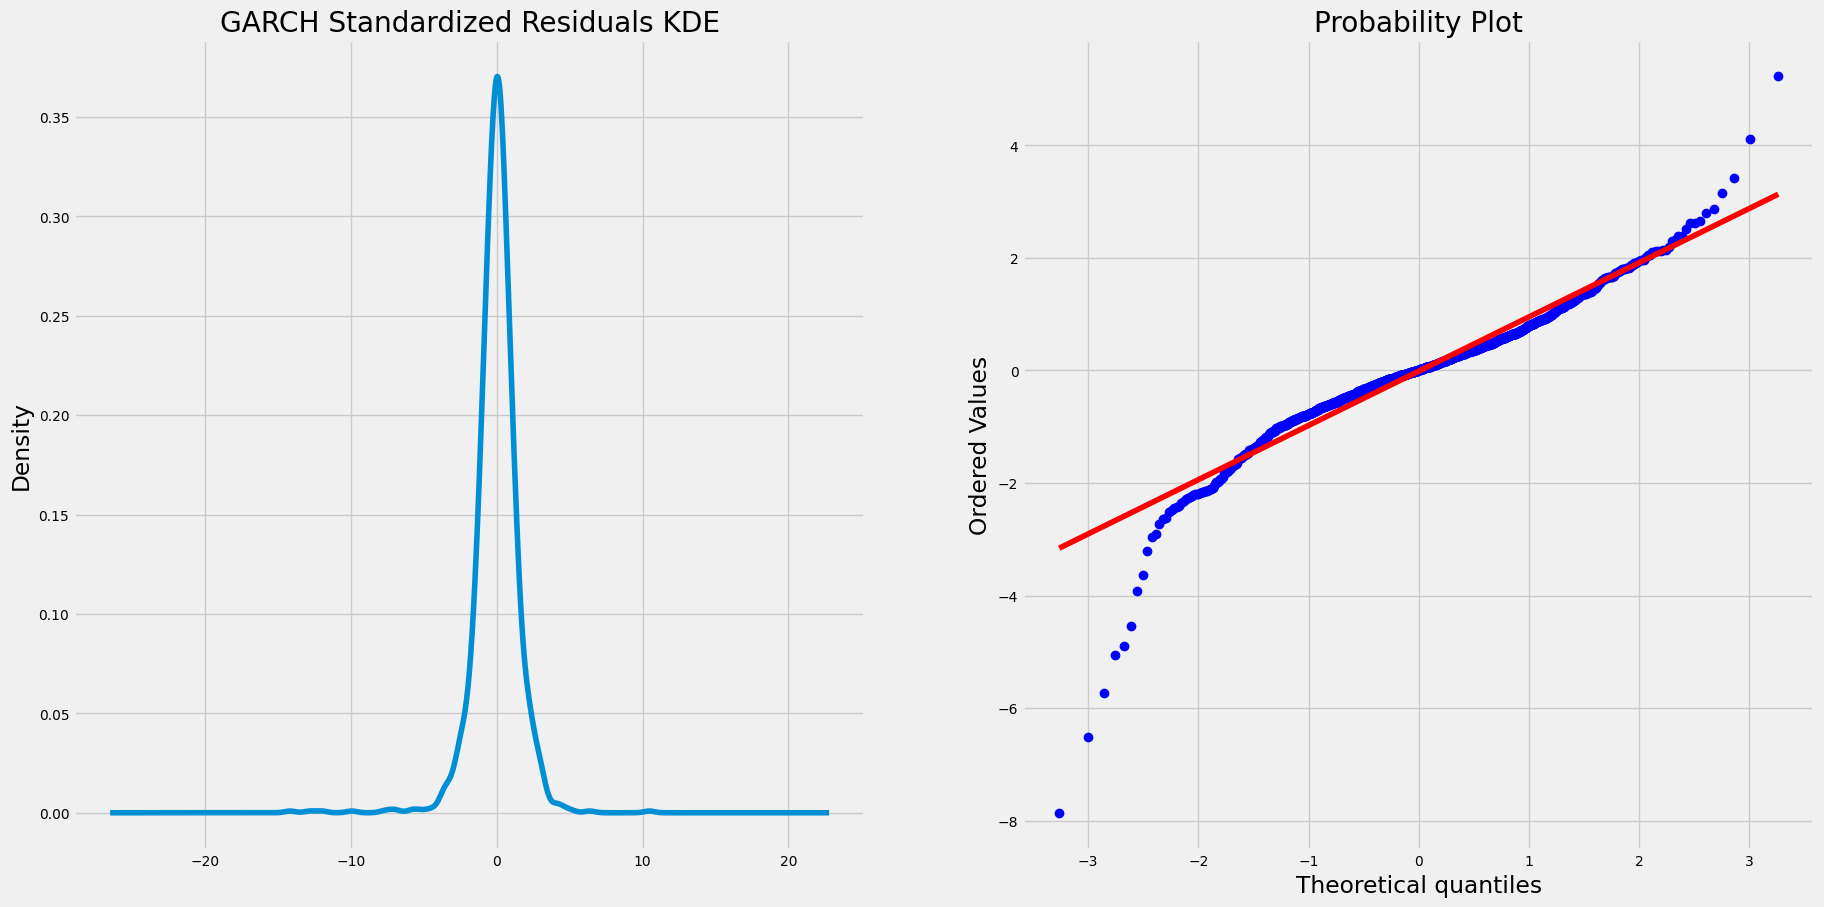

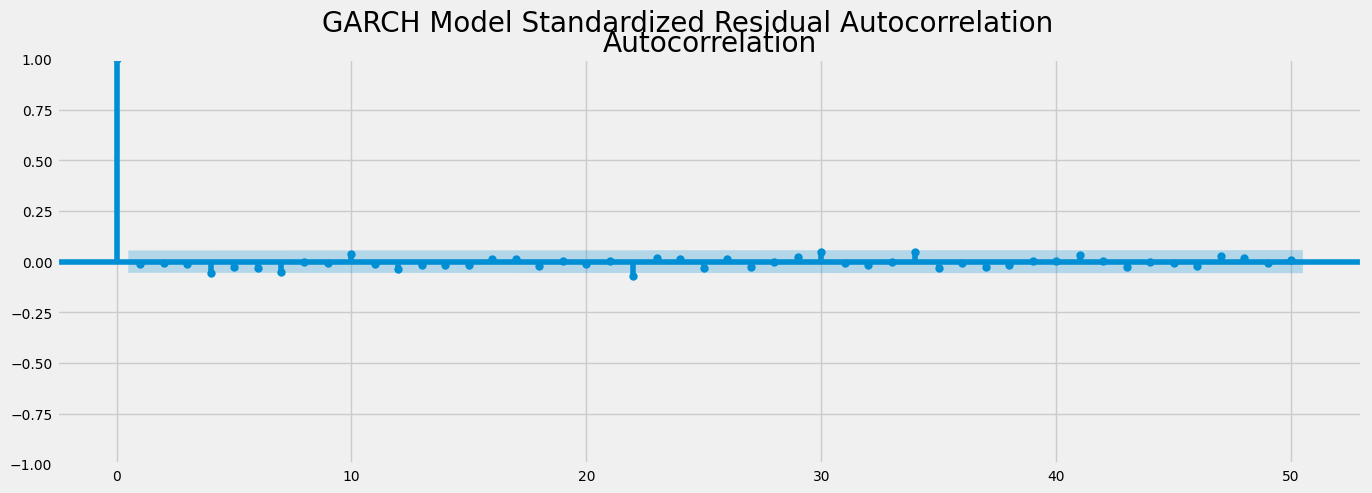

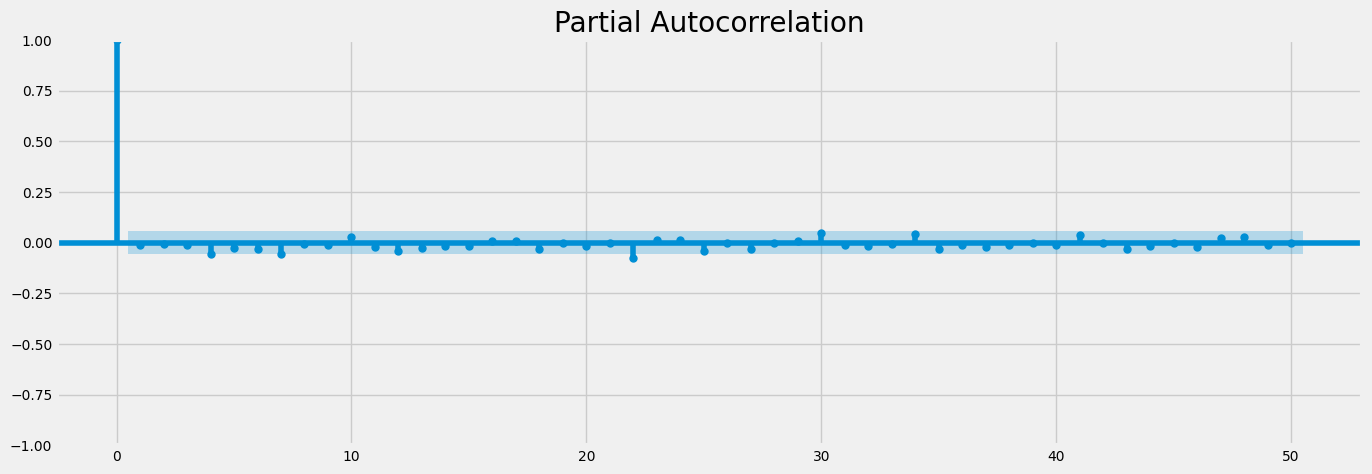

In [140]:
garch = arch_model(df['pct_change'], vol='GARCH', p=17, q=35, dist='normal')
fgarch = garch.fit(disp='off')
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)

In [141]:
arch_test = het_arch(resid, nlags=50)
shapiro_test = shapiro(st_resid)
print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 0.9999999997875755
F test p-value: 0.9999999998537852
Shapiro-Wilks p-value: 3.9709636859665505e-24


In [142]:
fgarch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2237.70
Distribution:                  Normal   AIC:                           4583.40
Method:            Maximum Likelihood   BIC:                           4860.81
                                        No. Observations:                 1258
Date:                Sun, Jul 21 2024   Df Residuals:                     1257
Time:                        01:43:42   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0980  5.084e-02      1.928  5.383e-02 [-1.616e-03,  0.198]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.3546      0.372      0.954      0.340      [ -0.374,  1.083]
alpha[1]   1.0242e-04  2.691e-02  3.806e-03      0.997 [-5.264e-02,5.284e-02]
alpha[2]   9.1937e-12  2.838e-02  3.240e-10      1.000 [-5.562e-02,5.562e-02]
alpha[3]   2.1080e-11  2.845e-02  7.411e-10      1.000 [-5.575e-02,5.575e-02]
alpha[4]       0.0918  8.829e-02      1.040      0.298   [-8.125e-02,  0.265]
alpha[5]   8.7609e-11  2.669e-02  3.283e-09      1.000 [-5.231e-02,5.231e-02]
alpha[6]   8.7452e-11  1.767e-02  4.950e-09      1.000 [-3.463e-02,3.463e-02]
alpha[7]   6.4657e-04  6.035e-02  1.071e-02      0.991      [ -0.118,  0.119]
alpha[8]   2.7915e-11  1.818e-02  1.535e-09      1.000 [-3.564e-02,3.564e-02]
alpha[9]   5.4309e-11  7.276e-03  7.464e-09      1.000 [-1.426e-02,1.426e-02]
alpha[10]  8.9053e-11  2.493e-02  3.571e-09      1.000 [-4.887e-02,4.887e-02]
alpha[11]  1.5375e-11  8.833e-02  1.741e-10      1.000      [ -0.173,  0.173]
alpha[12]      0.0512      0.101      0.508      0.612      [ -0.147,  0.249]
alpha[13]  6.3241e-11  2.004e-02  3.156e-09      1.000 [-3.928e-02,3.928e-02]
alpha[14]  1.1576e-10  3.583e-02  3.231e-09      1.000 [-7.022e-02,7.022e-02]
alpha[15]  4.7533e-03  2.026e-02      0.235      0.814 [-3.495e-02,4.445e-02]
alpha[16]      0.3149      0.188      1.678  9.336e-02   [-5.293e-02,  0.683]
alpha[17]      0.0349      0.171      0.204      0.838      [ -0.300,  0.370]
beta[1]    2.2937e-11      0.380  6.031e-11      1.000      [ -0.745,  0.745]
beta[2]    5.8023e-11      0.224  2.586e-10      1.000      [ -0.440,  0.440]
beta[3]    3.9349e-11      0.110  3.569e-10      1.000      [ -0.216,  0.216]
beta[4]    4.2661e-13      0.101  4.215e-12      1.000      [ -0.198,  0.198]
beta[5]    1.9335e-11  5.300e-02  3.648e-10      1.000      [ -0.104,  0.104]
beta[6]    3.0039e-11      0.211  1.426e-10      1.000      [ -0.413,  0.413]
beta[7]    4.8895e-11  9.099e-02  5.374e-10      1.000      [ -0.178,  0.178]
beta[8]    2.0721e-11      0.463  4.471e-11      1.000      [ -0.908,  0.908]
beta[9]    6.3621e-11  6.034e-02  1.054e-09      1.000      [ -0.118,  0.118]
beta[10]   5.9742e-12  2.413e-02  2.476e-10      1.000 [-4.728e-02,4.728e-02]
beta[11]   2.6805e-11  7.354e-02  3.645e-10      1.000      [ -0.144,  0.144]
beta[12]   3.4409e-11  4.592e-02  7.493e-10      1.000 [-9.000e-02,9.000e-02]
beta[13]   5.5297e-11      0.111  4.962e-10      1.000      [ -0.218,  0.218]
beta[14]   1.8882e-11      0.112  1.690e-10      1.0